In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from math import *
import qutip as qt
import qutip.qip
# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

# static image plots
%matplotlib inline
# interactive 3D plots
# %matplotlib widget

In [2]:
def photon_count_distribution(state: qt.Qobj):
    """
    Returns the photon number distribution P(n) for any state.
    """
    if state.isket:
        # For Kets: |Amplitude|^2
        # We flatten it to get a 1D array
        return np.abs(state.full().flatten())**2
    else:
        # For Density Matrices: Extract the diagonal
        # We take .real to discard any +0j imaginary artifacts
        return np.real(state.diag())

In [3]:
def join_modes(mode1: qt.Qobj, mode2: qt.Qobj) -> qt.Qobj:
    """Merges two independent modes into a joint Hilbert space (tensor product)."""
    return qt.tensor(mode1, mode2)

def separate_modes(joint_state: qt.Qobj):
    """
    Takes a joint state (2 modes) and returns the reduced density matrices 
    for mode 1 and mode 2 respectively (Partial Trace).
    """
    # Verify the state has two subsystems
    if len(joint_state.dims[0]) != 2:
        raise ValueError("State does not appear to be a 2-mode system.")
        
    return joint_state.ptrace(0), joint_state.ptrace(1)

def beamsplitter_general(input_state: qt.Qobj, input_2: qt.Qobj = None, transmissivity: float = 0.5) -> qt.Qobj:
    """
    Applies a beamsplitter interaction.
    
    Args:
        input_state: Either a joint state (2 modes) OR the state for Mode 1.
        input_2: (Optional) If input_state is Mode 1, this must be Mode 2.
        transmissivity: Probability of swapping modes (0 to 1).
                        T=0 is Identity, T=1 is full Swap, T=0.5 is 50:50.
    
    Returns:
        The evolved joint state (Ket or Density Matrix).
    """
    
    # 1. Standardize Input: Ensure we have one Joint State
    if input_2 is not None:
        # Case A: User provided two separate modes -> Tensor them
        state = qutip.tensor(input_state, input_2)
    else:
        # Case B: User provided a pre-existing joint state
        state = input_state
        # Validation: Ensure it actually has 2 modes
        if len(state.dims[0]) != 2:
            raise ValueError("Input provided is not a joint 2-mode system (dims must imply tensor structure).")

    # 2. Extract Dimensions
    # state.dims looks like [[N1, N2], [N1, N2]] for density matrices
    # or [[N1, N2], [1, 1]] for kets.
    # We grab the first list to get the Hilbert space sizes.
    N1 = state.dims[0][0]
    N2 = state.dims[0][1]

    if N1 != N2:
        # While physically possible, usually in simulation we keep cutoff dims identical
        # to allow swapping without dimension mismatch errors.
        raise ValueError(f"Mode dimensions mismatch: {N1} vs {N2}")
    
    N = N1

    # 3. Define Operators on the Joint Space
    a = qt.destroy(N)
    
    # a1 acts on first subspace, identity on second
    a1 = qt.tensor(a, qt.qeye(N))
    # a2 acts on identity on first, normal on second
    a2 = qt.tensor(qt.qeye(N), a)

    # 4. mixing angle theta
    # Transmissivity T = sin^2(theta)
    theta = np.arcsin(np.sqrt(transmissivity))

    # 5. Beamsplitter Unitary
    # U = exp( theta * (a1^dag a2 - a1 a2^dag) )
    generator = theta * (a1.dag() * a2 - a1 * a2.dag())
    U_bs = generator.expm()

    # 6. Apply Unitary
    if state.isket:
        return U_bs * state
    else:
        return U_bs * state * U_bs.dag()


def apply_loss_channel(input_qumode: qt.Qobj, trasmissivity: float):
    N_input = input_qumode.shape[0]
    vacuum = qt.basis(N_input, 0)
    output_qumode, _ = separate_modes(beamsplitter_general(input_qumode, vacuum, 1-trasmissivity))
    return output_qumode

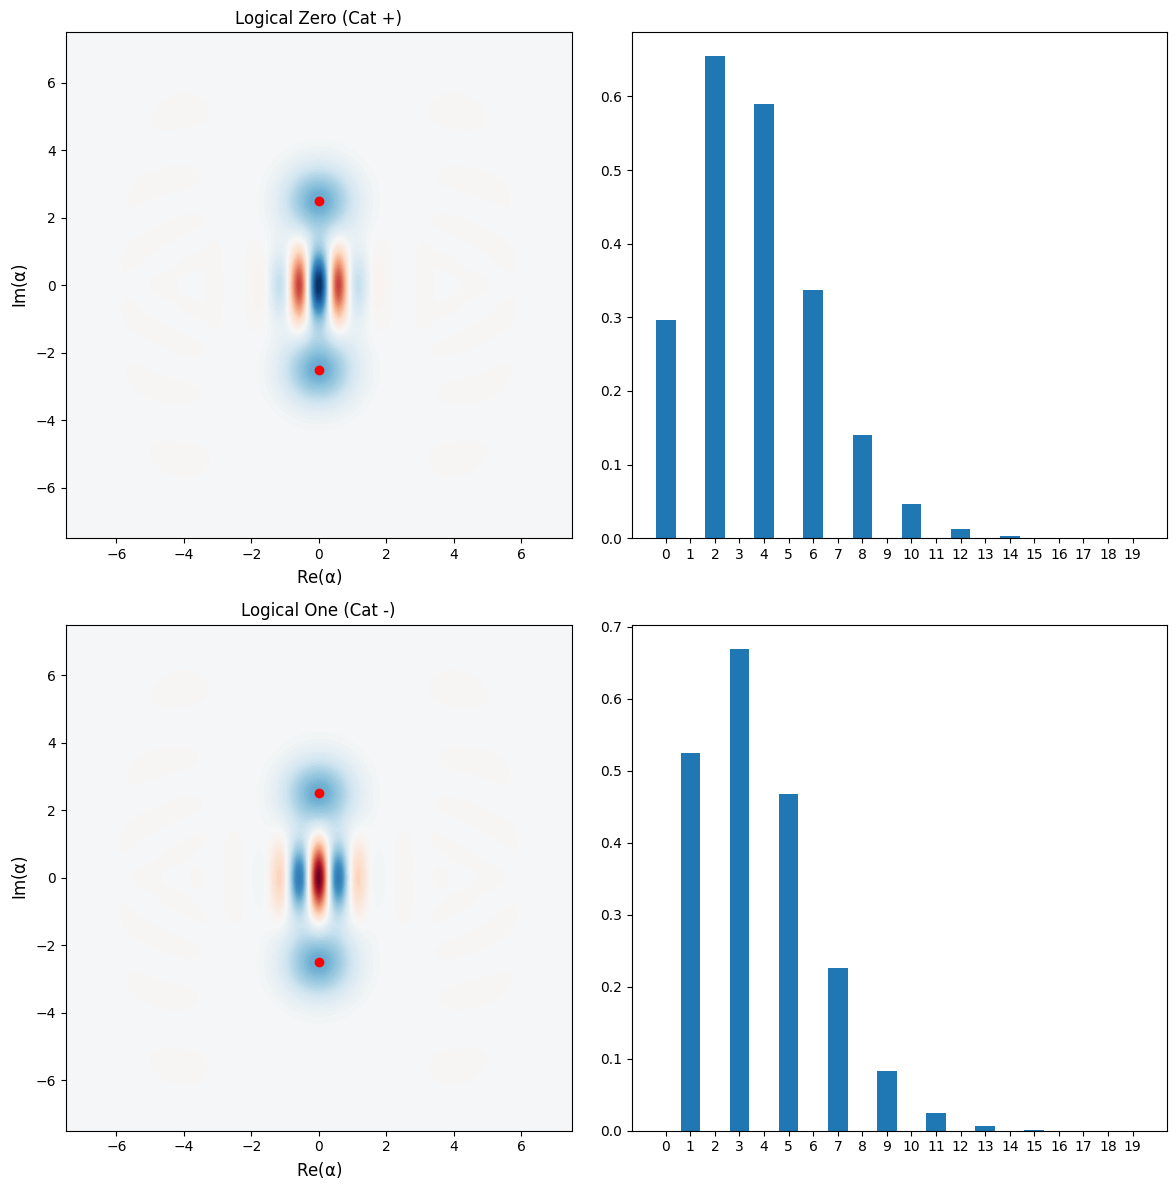

In [18]:
N = 20
vacuum = qt.basis(N, 0)

vertical_displacement = 2.5


alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qt.displace(N, alpha_coeff)
negative_displacement_operator = qt.displace(N, -alpha_coeff)


plus_alpha_state = positive_displacement_operator * vacuum
minus_alpha_state = negative_displacement_operator * vacuum

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()


fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(logical_zero, ax=axes[0, 0])
axes[0, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0, 0].set_title("Logical Zero (Cat +)")
qt.plot_wigner(logical_one, ax=axes[1, 0])
axes[1, 0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[1, 0].set_title("Logical One (Cat -)")


axes[0, 1].bar(np.arange(N), np.abs(logical_zero.full()).flatten())
axes[0, 1].set_xticks(np.arange(N))
axes[0, 1].set_aspect('auto')
axes[1, 1].bar(np.arange(N), np.abs(logical_one.full()).flatten())
axes[1, 1].set_xticks(np.arange(N))
axes[1, 1].set_aspect('auto')

plt.tight_layout()
plt.show()

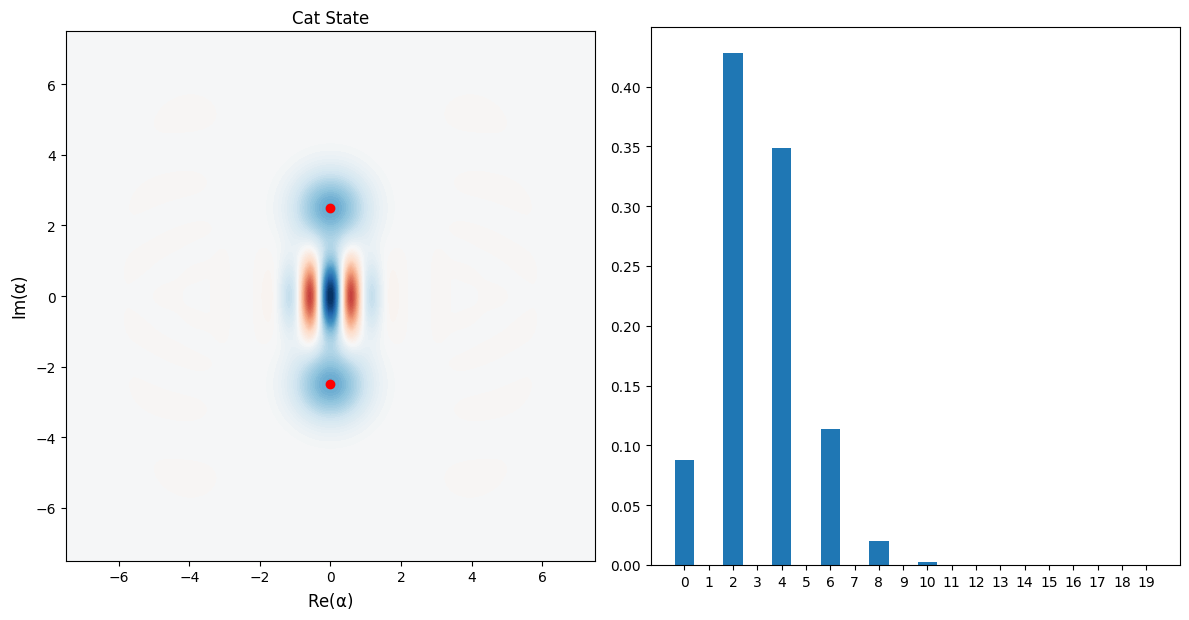

In [53]:
N = 20

H_I = qt.tensor(qutip.gates.snot(), qt.qeye(2))
CNOT = qt.gates.cnot()
tx_side_qubits = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
tx_side_qubits = H_I * tx_side_qubits
tx_side_qubits = CNOT * tx_side_qubits

tx_side_vacuum = qt.basis(N, 0)

dv_tensor_cv = qt.tensor(tx_side_qubits, tx_side_vacuum)


alpha = 2.5 * sqrt(2)  # The amplitude of the cat state




vacuum = qt.basis(N, 0)

vertical_displacement = 2.5


alpha_coeff = vertical_displacement / sqrt(2) * 1j
positive_displacement_operator = qt.displace(N, alpha_coeff)
negative_displacement_operator = qt.displace(N, -alpha_coeff)


plus_alpha_state = positive_displacement_operator * vacuum
minus_alpha_state = negative_displacement_operator * vacuum

logical_zero = (plus_alpha_state + minus_alpha_state).unit()
logical_one = (plus_alpha_state - minus_alpha_state).unit()



# 2. Lift these operators to the full 3-subsystem Hilbert space
# System order: [Qubit 0, Qubit 1, Oscillator]
# We want the gate to trigger based on Qubit 1 (index 1)
identity_q0 = qt.qeye(2)

# Create the Controlled-Displacement 
# This applies D_pos if Qubit 1 is |0> and D_neg if Qubit 1 is |1>
U_encode = (qt.tensor(identity_q0, qt.basis(2, 0).proj(), logical_zero * qt.basis(N, 0).dag()) + 
            qt.tensor(identity_q0, qt.basis(2, 1).proj(), logical_one * qt.basis(N, 0).dag()))

# 3. Apply the encoding to your existing tensor state
final_state = U_encode * dv_tensor_cv



# Projector for Qubit 0 onto the |1> state
proj_q0_zero = qt.tensor(qt.basis(2, 0).proj(), qt.qeye(2), qt.qeye(N))
proj_q0_one = qt.tensor(qt.basis(2, 1).proj(), qt.qeye(2), qt.qeye(N))

# Apply measurement and re-normalize
collapsed_state = (proj_q0_zero * final_state).unit()

# Extract the CV mode (index 2)
rho_cv = collapsed_state.ptrace(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(rho_cv, ax=axes[0])
axes[0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')
axes[0].set_title("Cat State")


axes[1].bar(np.arange(N), photon_count_distribution(rho_cv))
axes[1].set_xticks(np.arange(N))
axes[1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [108]:
def apply_cat_state_encoding(input_states, qubit_position, cv_position, vertical_displacement=2.5, N=20):
    # 1. Prepare CV states
    vacuum = qt.basis(N, 0)
    alpha_coeff = (vertical_displacement / np.sqrt(2)) * 1j
    
    pos_disp = qt.displace(N, alpha_coeff)
    neg_disp = qt.displace(N, -alpha_coeff)
    
    logical_zero = (pos_disp * vacuum + neg_disp * vacuum).unit()
    logical_one  = (pos_disp * vacuum - neg_disp * vacuum).unit()
    
    # Define the mapping operators for the CV mode
    map_zero = logical_zero * vacuum.dag()
    map_one  = logical_one * vacuum.dag()

    # 2. Build the operator list for the tensor product
    num_subsystems = len(input_states.dims[0])
    dims = input_states.dims[0] 

    def build_gate(qubit_state_index):
        op_list = [qt.qeye(dims[i]) for i in range(num_subsystems)]
        
        if qubit_state_index == 0:
            # Map: |0>_q |vac>_cv  ->  |0>_q |cat+>_cv
            op_list[qubit_position] = qt.basis(2, 0).proj()
            op_list[cv_position] = map_zero
        else:
            # Map: |1>_q |vac>_cv  ->  |0>_q |cat->_cv
            # We use |0><1| to flip the qubit from 1 to 0 during the transfer
            op_list[qubit_position] = qt.basis(2, 0) * qt.basis(2, 1).dag()
            op_list[cv_position] = map_one
        
        return qt.tensor(op_list)

    # 3. Combine into the full encoding operator
    U_encode = build_gate(0) + build_gate(1)

    return U_encode * input_states

In [ ]:
def measure_qubit(state, target_index, outcome):
    dims = state.dims[0]
    op_list = [qt.qeye(dims[i]) for i in range(len(dims))]
    
    # Set the projector at the desired index
    op_list[target_index] = qt.basis(2, outcome).proj()
    
    projector = qt.tensor(op_list)
    return (projector * state).unit()

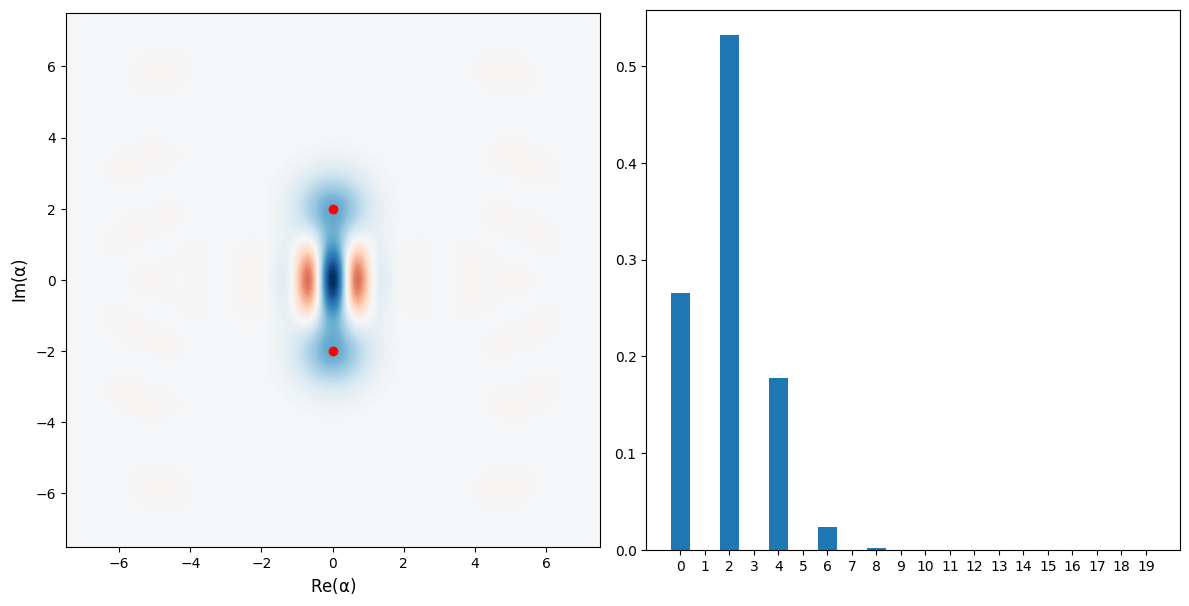

In [69]:
N = 20
vertical_displacement = 2

H_I = qt.tensor(qutip.gates.snot(), qt.qeye(2))
CNOT = qt.gates.cnot()
tx_side_qubits = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
tx_side_qubits = H_I * tx_side_qubits
tx_side_qubits = CNOT * tx_side_qubits

tx_side_vacuum = qt.basis(N, 0)

tx_side_states = qt.tensor(tx_side_qubits, tx_side_vacuum)

tx_side_states = apply_cat_state_encoding(tx_side_states, 1, 2, vertical_displacement)



collapsed = measure_qubit(tx_side_states, 0, 0)
rho_cv = collapsed.ptrace(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(rho_cv, ax=axes[0])
axes[0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')

axes[1].bar(np.arange(N), photon_count_distribution(rho_cv))
axes[1].set_xticks(np.arange(N))
axes[1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [70]:
def beamsplitter_general(input_state: qt.Qobj, idx1: int, idx2: int, transmissivity: float) -> qt.Qobj:
    # 1. Get the global dimensions of the system
    # dims will be something like [2, 2, 20, 20] (Qubit0, Qubit1, CV0, CV1)
    dims = input_state.dims[0]
    num_subsystems = len(dims)
    
    # 2. Extract cutoff dimensions for the two target CV modes
    N1 = dims[idx1]
    N2 = dims[idx2]
    
    # 3. Create the annihilation operators in the full Hilbert space
    # We start with a list of identities for every subsystem
    op_list1 = [qt.qeye(d) for d in dims]
    op_list2 = [qt.qeye(d) for d in dims]
    
    # Replace the identities at the target indices with destroy operators
    op_list1[idx1] = qt.destroy(N1)
    op_list2[idx2] = qt.destroy(N2)
    
    # Tensor them together to get operators acting on the full system
    a1 = qt.tensor(op_list1)
    a2 = qt.tensor(op_list2)

    # 4. Calculate mixing angle
    theta = np.arcsin(np.sqrt(transmissivity))

    # 5. Build the Unitary for the full space
    # U = exp( theta * (a1^dag a2 - a1 a2^dag) )
    generator = theta * (a1.dag() * a2 - a1 * a2.dag())
    U_bs = generator.expm()

    # 6. Apply and return
    if input_state.isket:
        return U_bs * input_state
    else:
        return U_bs * input_state * U_bs.dag()

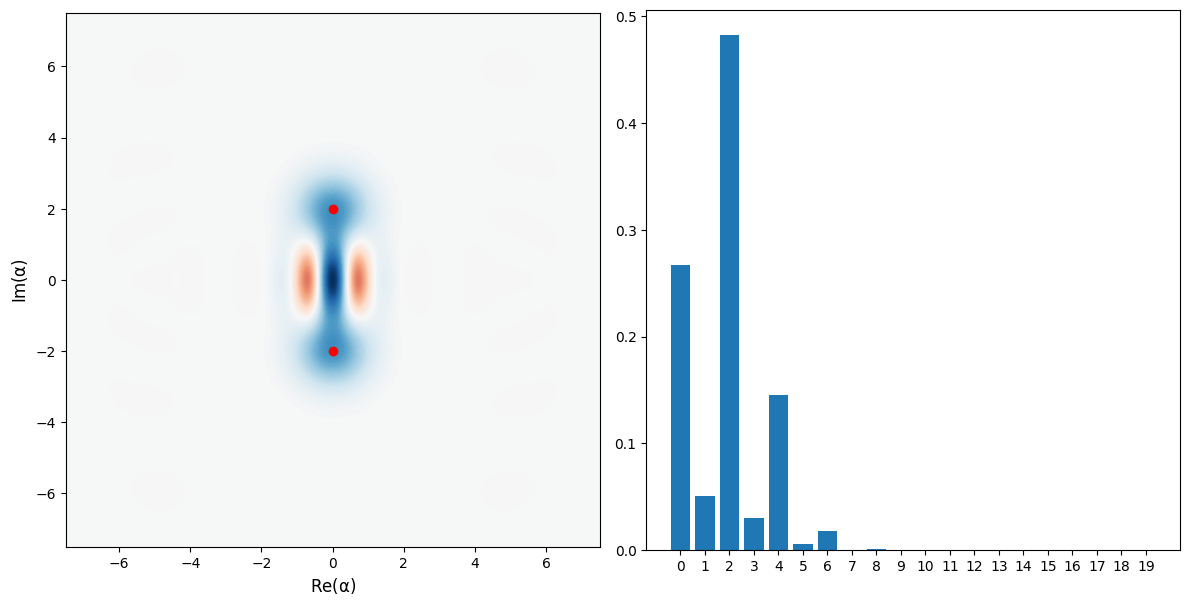

In [76]:
N = 20
vertical_displacement = 2

H_I = qt.tensor(qutip.gates.snot(), qt.qeye(2))
CNOT = qt.gates.cnot()
tx_side_qubits = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
tx_side_qubits = H_I * tx_side_qubits
tx_side_qubits = CNOT * tx_side_qubits

tx_side_vacuum = qt.basis(N, 0)

tx_side_states = qt.tensor(tx_side_qubits, tx_side_vacuum) # Encoded Cat state is in position 2

tx_side_states = apply_cat_state_encoding(tx_side_states, 1, 2, vertical_displacement)

full_channel_states = qt.tensor(tx_side_states, qt.basis(N, 0)) # Adds vacuum used for beamsplitter in position 3

full_channel_states = beamsplitter_general(full_channel_states, 2, 3, 0.05)


collapsed = measure_qubit(full_channel_states, 0, 0)
rho_cv = collapsed.ptrace(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6),  subplot_kw={'aspect': 'equal'})
qt.plot_wigner(rho_cv, ax=axes[0])
axes[0].plot([0, 0], [vertical_displacement, -vertical_displacement], 'ro')

axes[1].bar(np.arange(N), photon_count_distribution(rho_cv))
axes[1].set_xticks(np.arange(N))
axes[1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [77]:
def apply_cat_state_decoding(input_states, qubit_position, cv_position, vertical_displacement=2.5, N=20):
    dims = input_states.dims[0]
    
    # 1. Define states
    vacuum = qt.basis(N, 0)
    alpha_coeff = (vertical_displacement / np.sqrt(2)) * 1j
    
    # Define logical states for parity detection
    pos_disp = qt.displace(N, alpha_coeff)
    neg_disp = qt.displace(N, -alpha_coeff)
    logical_zero_cv = (pos_disp * vacuum + neg_disp * vacuum).unit()
    logical_one_cv  = (pos_disp * vacuum - neg_disp * vacuum).unit()

    # 2. Step A: Parity-Controlled Qubit Flip (The "Decoding")
    # This maps: |cat+>|0> -> |cat+>|0>  AND  |cat->|0> -> |cat->|1>
    def build_flip():
        # Project CV onto Parity, apply corresponding gate to Qubit
        op_plus = [qt.qeye(d) for d in dims]
        op_plus[cv_position] = logical_zero_cv.proj()
        # Qubit stays same (Identity)
        
        op_minus = [qt.qeye(d) for d in dims]
        op_minus[cv_position] = logical_one_cv.proj()
        op_minus[qubit_position] = qt.sigmax() # Flip if odd parity
        
        return qt.tensor(op_plus) + qt.tensor(op_minus)

    # 3. Step B: Qubit-Controlled Un-displacement (The "Cleaning")
    # This returns the CV mode to vacuum: |cat+>|0> -> |vac>|0> AND |cat->|1> -> |vac>|1>
    # Note: This is essentially the inverse of your encoding function.
    def build_clean():
        # This part ensures the operation is unitary by resetting the CV mode
        op_zero = [qt.qeye(d) for d in dims]
        op_zero[qubit_position] = qt.basis(2, 0).proj()
        op_zero[cv_position] = vacuum * logical_zero_cv.dag()
        
        op_one = [qt.qeye(d) for d in dims]
        op_one[qubit_position] = qt.basis(2, 1).proj()
        op_one[cv_position] = vacuum * logical_one_cv.dag()
        
        return qt.tensor(op_zero) + qt.tensor(op_one)

    # Combined Unitary: First flip the qubit, then clean the CV mode
    U_total = build_clean() * build_flip()
    
    return U_total * input_states

In [88]:
N = 20
vertical_displacement = 3
loss_prob = 0.001

H_I = qt.tensor(qutip.gates.snot(), qt.qeye(2))
CNOT = qt.gates.cnot()
tx_side_qubits = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
tx_side_qubits = H_I * tx_side_qubits
tx_side_qubits = CNOT * tx_side_qubits
tx_side_vacuum = qt.basis(N, 0)
tx_side_states = qt.tensor(tx_side_qubits, tx_side_vacuum) # Encoded Cat state is in position 2
tx_side_states = apply_cat_state_encoding(tx_side_states, 1, 2, vertical_displacement)
full_channel_states = qt.tensor(tx_side_states, qt.basis(N, 0)) # Adds vacuum used for beamsplitter in position 3
full_channel_states = beamsplitter_general(full_channel_states, 2, 3, loss_prob)

complete_system = qt.tensor(full_channel_states, qt.basis(2, 0))
complete_system = apply_cat_state_decoding(complete_system, 4, 2, vertical_displacement, N)

collapsed = measure_qubit(complete_system, 0, 1)
remote_qubit = collapsed.ptrace(4)
print(remote_qubit)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.00448093 0.        ]
 [0.         0.99551907]]


In [94]:
def apply_hadamard(state, target_idx):
    dims = state.dims[0]
    op_list = [qt.qeye(d) for d in dims]
    
    # Place Hadamard at the target index
    op_list[target_idx] = qt.gates.snot()
    
    H_total = qt.tensor(op_list)
    return H_total * state

def apply_cnot(state, control_idx, target_idx):
    dims = state.dims[0]
    
    # Part 1: Control is in |0> (Identity on target)
    op_list_0 = [qt.qeye(d) for d in dims]
    op_list_0[control_idx] = qt.basis(2, 0).proj()
    # Target stays Identity, so no change needed to op_list_0
    
    # Part 2: Control is in |1> (X on target)
    op_list_1 = [qt.qeye(d) for d in dims]
    op_list_1[control_idx] = qt.basis(2, 1).proj()
    op_list_1[target_idx] = qt.sigmax()
    
    CNOT_total = qt.tensor(op_list_0) + qt.tensor(op_list_1)
    return CNOT_total * state

In [114]:
N = 20
vertical_displacement = 3
loss_prob = 0.01


all_states = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), qt.basis(N, 0), qt.basis(N, 0), qt.basis(2, 0))
all_states = apply_hadamard(all_states, 0)
all_states = apply_cnot(all_states, 0, 1)
all_states = apply_cat_state_encoding(all_states, 1, 2, vertical_displacement)
all_states = beamsplitter_general(all_states, 2, 3, loss_prob)

all_states = apply_cat_state_decoding(all_states, 4, 2, vertical_displacement, N)

edge_qubits = all_states.ptrace([0, 4])
print(edge_qubits)

# Define ideal Phi+ state: (|00> + |11>) / sqrt(2)
ideal_phi_plus = (qt.tensor(qt.basis(2,0), qt.basis(2,0)) + 
                  qt.tensor(qt.basis(2,1), qt.basis(2,1))).unit()
ideal_rho = qt.ket2dm(ideal_phi_plus)

# Calculate Fidelity (1.0 is perfect)
fid = qt.fidelity(edge_qubits, ideal_rho)
print(f"Fidelity with Phi+: {fid:.4f}")

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.47843417 0.         0.         0.4784287 ]
 [0.         0.02150917 0.02151476 0.        ]
 [0.         0.02151476 0.02152035 0.        ]
 [0.4784287  0.         0.         0.47842322]]
Fidelity with Phi+: 0.9782
